In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
import torch.optim as optim

In [2]:
n1 = 262144
n2 = 13
nx = 512
nz = 512
f_vel = "/var/tmp/tccs/lfd/twod/vel7_t.rsf@"
f_coe = "/var/tmp/tccs/lfd/twod/G_10_2.rsf@"

In [3]:
def image(data):
    plt.figure(figsize=(7, 7))
    plt.imshow(data)
    plt.colorbar()
    plt.show()


def plot(x, y):
    plt.figure(figsize=(7, 7))
    plt.plot(x, y, marker='o', color='red')
    plt.show()

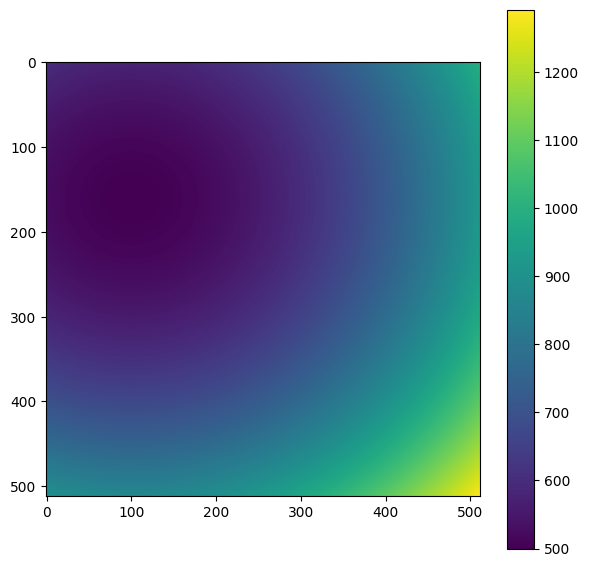

In [4]:
vel = np.fromfile(f_vel, dtype=np.float32).reshape((n1))
image(vel.reshape((nx, nz)))

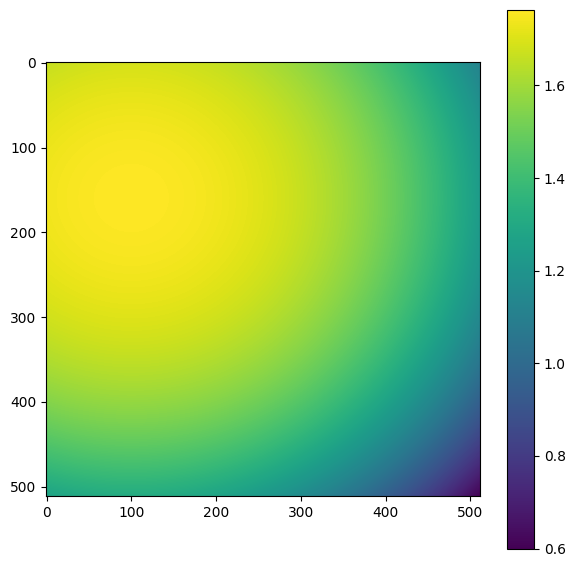

In [5]:
coeff = np.fromfile(f_coe, dtype=np.float32).reshape((13, n1))
image(coeff[0].reshape((nx, nz)))

In [16]:
sorted_indices = np.argsort(vel)
x = vel[sorted_indices]
y = coeff.transpose()[sorted_indices]

# x_min, x_max = x.min(), x.max()
# y_min, y_max = y.min(), y.max()
# x_norm = (x - x_min) / (x_max - x_min)
# y_norm = (y - y_min) / (y_max - y_min)

x_tensor = torch.tensor(x, dtype=torch.float32).reshape((n1, 1))
y_tensor = torch.tensor(y, dtype=torch.float32).reshape((n1, 13))


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 13)
        self.activation = nn.ReLU()  # 也可以换成 nn.Swish()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # 输出层不用激活
        return x

In [17]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [18]:
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(x_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.10f}")

Epoch 0, Loss: 495.4594726562
Epoch 100, Loss: 0.1621995270
Epoch 200, Loss: 0.1030345336
Epoch 300, Loss: 0.0587791391
Epoch 400, Loss: 0.0315681882
Epoch 500, Loss: 0.0170278456
Epoch 600, Loss: 0.0101817716
Epoch 700, Loss: 0.0073321508
Epoch 800, Loss: 0.0062826942
Epoch 900, Loss: 0.0059408513


In [31]:
x_test = torch.linspace(x.min(), x.max(), 1000).view(-1, 1)  # 归一化范围
y_pred = model(x_test)

x_t = x_test.transpose().detach().numpy()
print(x_t)

TypeError: transpose() received an invalid combination of arguments - got (), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


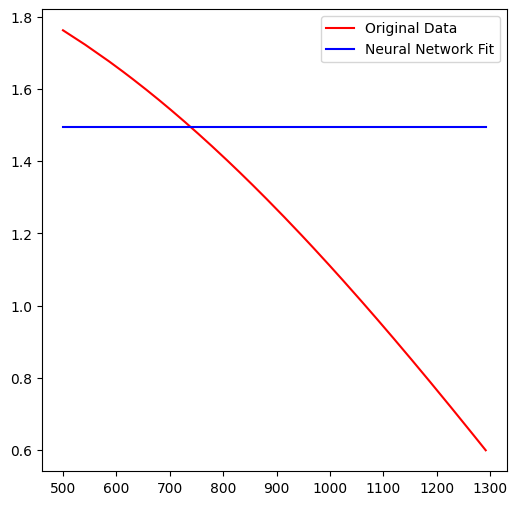

In [27]:
plt.figure(figsize=(6, 6))
plt.plot(x, y[:, 0], color='red', label="Original Data")
plt.plot(x_test.transpose(0, 1).detach().numpy().reshape((1000)), y_pred[0], color='blue', label="Neural Network Fit")
plt.legend()
plt.show()

In [11]:
print(x_min, x_max)

500.0 1291.9055
